# Time Series Classification - User Identification

In [44]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import os

import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py

from plotly.subplots import make_subplots

from sklearn.metrics import (
    make_scorer,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
)

from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate

from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline

warnings.filterwarnings(action="once")
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

%matplotlib inline

## Read in Data

In [45]:
train_df = pd.read_csv("user_ident_class_train.csv")
print(train_df.shape)
train_df.head(3)

(104532, 5)


,time_step,x_accel,y_accel,z_accel,user_id
0,0.00000,0.69464,3.17350,7.50480,1
1,0.03064,0.14982,3.48680,9.27550,1
2,0.06976,-0.29965,1.94770,9.11200,1


In [46]:
test_df = pd.read_csv("user_ident_class_test.csv")
print(test_df.shape)
test_df.head(3)

(44800, 5)


,time_step,x_accel,y_accel,z_accel,user_id
0,107.38000,-4.98500,10.18800,-2.83300,1
1,107.41000,-3.97710,8.28120,-3.44590,1
2,107.44000,-5.85670,8.92130,-4.63090,1


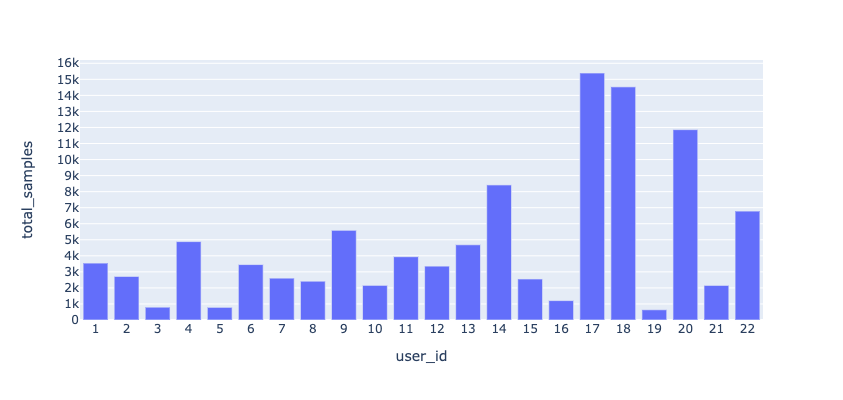

In [47]:
train_samples_df = pd.DataFrame(train_df.user_id.value_counts()).reset_index()
train_samples_df.columns = ["user_id", "total_samples"]
train_samples_df = train_samples_df.sort_values("user_id")

fig = px.bar(train_samples_df, x="user_id", y="total_samples")
fig.update_xaxes(nticks=23)
fig.update_yaxes(nticks=20)
fig.update_layout(width=800, height=400)
py.offline.iplot(fig)

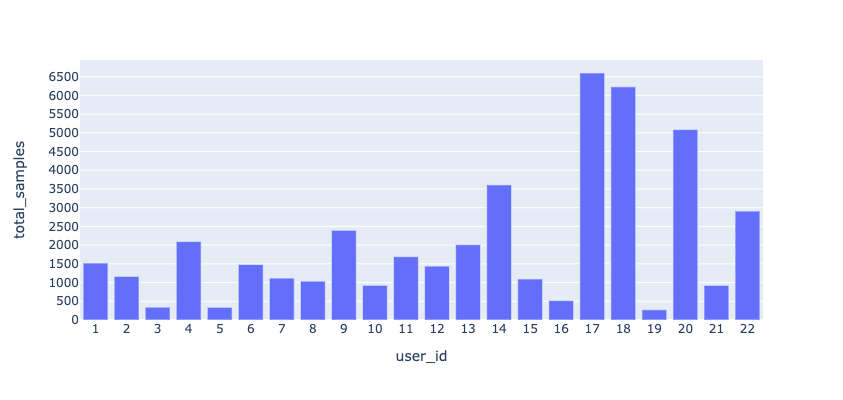

In [48]:
test_samples_df = pd.DataFrame(test_df.user_id.value_counts()).reset_index()
test_samples_df.columns = ["user_id", "total_samples"]
test_samples_df = test_samples_df.sort_values("user_id")

fig = px.bar(test_samples_df, x="user_id", y="total_samples")
fig.update_xaxes(nticks=23)
fig.update_yaxes(nticks=20)
fig.update_layout(width=800, height=400)
py.offline.iplot(fig)

## Turn into sktime

In [49]:
def get_window_seq_series(val_series, window_size, step_size):
    final_list = []
    for i in range(0, len(val_series), step_size):
        window_list = val_series.iloc[i:(i+window_size)]
        if len(window_list) == window_size:
            final_list.append(window_list)
    return final_list

In [50]:
def get_window_seq_series_col(df, cols, window_size, step_size):
    user_dic = {}
    for user_id in df.user_id.unique():
        udf = df[df["user_id"] == user_id]
        udf = udf.set_index("time_step")
        #print(udf.shape)
        col_dic = {}
        for col in cols:
            udf_col_series = udf[col]
            #print(udf_xaccel.iloc[0:5])
            window_list = get_window_seq_series(udf_col_series, window_size, step_size)
            col_dic[col] = window_list
        user_dic[user_id] = col_dic
    return user_dic

In [51]:
def get_window_seq_series_df(df, cols, window_size, step_size):
    # user_col_dic is nested dictionary key user_id -> col_dic which contains 
    # the columns as keys like x_accel, y_accel which returns a list 
    #of pandas series (time series and col vals)
    user_col_dic = get_window_seq_series_col(df, cols, window_size, step_size)
    
    udf_list = []
    for user_id in user_col_dic.keys():
        ucol_dic = user_col_dic[user_id]
        udf = pd.DataFrame(ucol_dic)
        udf["user_id"] = user_id
        udf_list.append(udf)
    fudf = pd.concat(udf_list)
    
    return fudf

In [52]:
window_size = 100
step_size = 5
cols = ["x_accel", "y_accel", "z_accel"]
train_wind_df = get_window_seq_series_df(train_df, cols, window_size, step_size)

In [53]:
print(train_wind_df.shape)
train_wind_df.head(2)

(20480, 4)


,x_accel,y_accel,z_accel,user_id
0,time_step 0.00000 0.69464 0.03064 0.1498...,time_step 0.00000 3.17350 0.03064 3.4868...,time_step 0.00000 7.50480 0.03064 9.2755...,1
1,time_step 0.15979 -2.30180 0.18982 -1.4165...,time_step 0.15979 0.23155 0.18982 1.1850...,time_step 0.15979 10.65100 0.18982 11.0730...,1


In [54]:
window_size = 100
step_size = 5
cols = ["x_accel", "y_accel", "z_accel"]
test_wind_df = get_window_seq_series_df(test_df, cols, window_size, step_size)

In [55]:
print(test_wind_df.shape)
test_wind_df.head(2)

(8534, 4)


,x_accel,y_accel,z_accel,user_id
0,time_step 107.38000 -4.98500 107.41000 -3....,time_step 107.38000 10.18800 107.41000 8....,time_step 107.38000 -2.83300 107.41000 -3....,1
1,time_step 107.53000 -2.87390 107.56000 -0....,time_step 107.53000 6.70120 107.56000 6....,time_step 107.53000 -1.52550 107.56000 1....,1


In [56]:
X_train = train_wind_df.copy()
del X_train["user_id"]
y_train = train_wind_df["user_id"]

In [57]:
X_train.head(2)

,x_accel,y_accel,z_accel
0,time_step 0.00000 0.69464 0.03064 0.1498...,time_step 0.00000 3.17350 0.03064 3.4868...,time_step 0.00000 7.50480 0.03064 9.2755...
1,time_step 0.15979 -2.30180 0.18982 -1.4165...,time_step 0.15979 0.23155 0.18982 1.1850...,time_step 0.15979 10.65100 0.18982 11.0730...


In [58]:
%%time

minirocket = MiniRocketMultivariate(num_features=5000)  # by default, ROCKET uses 10,000 kernels
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)

CPU times: user 23min 4s, sys: 688 ms, total: 23min 4s
Wall time: 1min 34s


In [59]:
X_train_transform.shape

(20480, 4956)

In [60]:
%%time
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train)

CPU times: user 13min 5s, sys: 2min 37s, total: 15min 42s
Wall time: 1min 25s


RidgeClassifierCV(alphas=array([   0.001     ,    0.00464159,    0.02154435,    0.1       ,
          0.46415888,    2.15443469,   10.        ,   46.41588834,
        215.443469  , 1000.        ]),
                  normalize=True)

In [61]:
X_test = test_wind_df.copy()
del X_test["user_id"]
y_test = test_wind_df["user_id"]
X_test_transform = minirocket.transform(X_test)

In [62]:
classifier.score(X_test_transform, y_test)

0.6972111553784861

In [63]:
classifier.score(X_train_transform, y_train)

1.0

In [70]:
def get_classification_report(clf, X_test, y_test, title):
    print(title)
    y_pred = clf.predict(X_test)
    class_report_dic = classification_report(y_test, y_pred, output_dict=True)
    class_report_df = pd.DataFrame(class_report_dic).T
    return class_report_df

In [71]:
get_classification_report(classifier, X_test_transform, y_test, "test")

test


/home/ubuntu/virtualenvs/py3_6_dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/virtualenvs/py3_6_dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ubuntu/virtualenvs/py3_6_dev/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,precision,recall,f1-score,support
1,0.96667,0.71228,0.82020,285.00000
2,0.46862,0.52336,0.49448,214.00000
3,0.00000,0.00000,0.00000,49.00000
4,0.52000,0.19549,0.28415,399.00000
5,0.61290,0.39583,0.48101,48.00000
6,0.81707,0.96751,0.88595,277.00000
7,0.40541,0.73529,0.52265,204.00000
8,0.24219,0.16489,0.19620,188.00000
9,0.78237,0.61739,0.69016,460.00000
10,0.96575,0.84940,0.90385,166.00000


In [68]:
def accuracy_scores(clf, X_test, y_test, model_name=""):
    predictions = clf.predict(X_test)
    acc_score = accuracy_score(y_test, predictions)
    # handle class imbalance, interesting other metric
    bal_acc_score = balanced_accuracy_score(y_test, predictions)
    test_acc_str = "{0} - test accuracy: {1:.5f} , balanced test accuracy: {2:.5f}"
    print(test_acc_str.format(model_name, acc_score, bal_acc_score))
    return acc_score, bal_acc_score

In [73]:
accuracy_scores(classifier, X_test_transform, y_test, "test")

test - test accuracy: 0.69721 , balanced test accuracy: 0.60502


(0.6972111553784861, 0.6050188827850502)

## Testing

In [17]:
train_df.head(2)

,time_step,x_accel,y_accel,z_accel,user_id
0,0.00000,0.69464,3.17350,7.50480,1
1,0.03064,0.14982,3.48680,9.27550,1


In [9]:
from sktime.utils.data_processing import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
    is_nested_dataframe,
)

In [15]:
tdf = from_2d_array_to_nested(train_df.head())

In [16]:
tdf.iloc[0]

0    0   0.00000
1   0.69464
2   3.17350
3   7.5048...
Name: 0, dtype: object

In [ ]:
from_2d_array_to_nested(train_df.head(), columns)

In [31]:
from numpy.random import default_rng

from sktime.utils.data_processing import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
    is_nested_dataframe,
)

rng = default_rng()
X_2d = rng.standard_normal((20, 5))
print(f"The tabular data has the shape {X_2d.shape}")

The tabular data has the shape (20, 5)


In [32]:
pd.DataFrame(X_2d)

,0,1,2,3,4
0,1.67708,-1.14074,0.31006,0.35139,0.10805
1,-0.95113,0.14243,-2.06544,-0.05182,0.29571
2,-0.10778,-0.47331,1.40403,-0.47188,-0.44856
3,-1.01537,-1.57831,0.96611,1.91356,1.22838
4,-0.12686,0.68289,-0.17845,-1.29778,-0.36145
5,0.15714,-2.46224,0.29604,-0.27567,-0.51558
6,-0.77941,-0.19628,-1.29413,-0.04375,-1.67484
7,1.07902,-0.57340,-0.85825,-1.18130,-1.84026
8,-0.32689,0.63754,0.74572,0.87269,1.99603
9,-0.70584,0.12310,0.93089,1.86327,0.90425


In [33]:
X_nested = from_2d_array_to_nested(X_2d)
print(f"X_nested is a nested DataFrame: {is_nested_dataframe(X_nested)}")
print(f"The cell contains a {type(X_nested.iloc[0,0])}.")
print(f"The nested DataFrame has shape {X_nested.shape}")
X_nested.head()

X_nested is a nested DataFrame: True
The cell contains a <class 'pandas.core.series.Series'>.
The nested DataFrame has shape (20, 1)


,0
0,0 1.67708 1 -1.14074 2 0.31006 3 0....
1,0 -0.95113 1 0.14243 2 -2.06544 3 -0....
2,0 -0.10778 1 -0.47331 2 1.40403 3 -0....
3,0 -1.01537 1 -1.57831 2 0.96611 3 1....
4,0 -0.12686 1 0.68289 2 -0.17845 3 -1....


In [45]:
X_nested.iloc[0]

0    0    1.67708
1   -1.14074
2    0.31006
3    0....
Name: 0, dtype: object

need to convert test_df, train_df to smaller windows

so for example each instance is a window of size 100 values sequentually, 